# setup django env

## db server

## environment

# confirm apis

## crop pic by skimage?

# retrieve

## nmslib 
这是一个大问题，需要更多的算法，做更好的比较
## plot nmslib result on x-y plot

# aligner
初步认为是因为人脸没有对齐，导致索引极差。但这个事情应分析下facenet的训练要求才能解决

# f1 score


# 想法
把这几个识别库单独拿出来，做成一个开发包，与Django和Celery分开使用

In [1]:
import numpy as np
import pandas as pd
import sys
import os

In [6]:
import sys
import os
import django
def start_local():
    os.environ["DOCKER_MODE"] = "true"
    os.environ["RABBIT_HOST"]= "localhost"
    os.environ["RABBIT_USER"] = "dvauser"
    os.environ["RABBIT_PASS"] = "localpass"

    # db
    os.environ["DB_HOST"] = "localhost"
    os.environ["DB_NAME"] = "postgres"
    os.environ["DB_USER"] = "pgdbuser"
    os.environ["DB_PASS"] = "pgdbpass"

    os.environ["LAUNCH_SERVER"] = "1"
    os.environ["LAUNCH_BY_NAME_indexer_inception"] = "1"
    os.environ["LAUNCH_BY_NAME_indexer_facenet"] = "1"
    os.environ["LAUNCH_BY_NAME_retriever_inception"] = "1"
    os.environ["LAUNCH_BY_NAME_retriever_facenet"] = "1"
    os.environ["LAUNCH_BY_NAME_detector_coco"] = "1"
    os.environ["LAUNCH_BY_NAME_analyzer_crnn"] = "1"
    os.environ["LAUNCH_BY_NAME_analyzer_tagger"] = "1"
    os.environ["LAUNCH_BY_NAME_detector_face"] = "1"
    os.environ["LAUNCH_Q_qclusterer"] = "1"
    os.environ["LAUNCH_Q_qextract"] = "1"
    os.environ["LAUNCH_SCHEDULER"] = "1"
    # export  TEST=1
    os.environ["AUTH_DISABLED"] = "1"
    dva_home = "/home/tom/ai/DeepVideoAnalytics"
    sys.path.append(os.path.abspath(dva_home))
    
    os.environ.setdefault("DJANGO_SETTINGS_MODULE", "dva.settings")
    django.setup()
    
start_local()

In [2]:
bmp = "/home/tom/ai.dataset.images/Face/222/222_0.bmp"
temppath = "/home/tom/ai.dataset.images.tmp"

In [2]:
import dvalib.indexer
facenet_index = dvalib.indexer.FacenetIndexer(os.path.join(
    "/home/tom/ai/DeepVideoAnalytics/dva/media/indexers/2",
    "facenet.pb"))
facenet_index.load()

In [109]:
bmp = "/home/tom/ai.dataset.images/Face/222/222_0.bmp"
from dvalib import detector
reload(detector)
detect =detector.FaceDetector()
detect.load()
import scipy.misc as misc
    
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def drawLandmark(img, xs, ys, size=2):
    result = img.copy()
    assert len(xs) == len(ys)
    # draw landmarks
    if img.shape[2]==3 :
        value = [255,0,0]
    elif img.shape[2]== 4:
        value = [255,0,0,0]
    else:
        return
        
    for i in range(len(xs)):
        result[ int(xs[i])-size:int(xs[i])+size, int(ys[i])-size:int(ys[i])+size] = value
        
    return result

def drawLandmarkXy(img, xys, size=2):
    result = img.copy()
    # draw landmarks
    if img.shape[2]==3 :
        value = [255,0,0]
    elif img.shape[2]== 4:
        value = [255,0,0,0]
    else:
        return
        
    for i in range(len(xys)):
        result[ int(xys[i][0])-size:int(xys[i][0])+size, int(xys[i][1])-size:int(xys[i][1])+size] = value
        
    return result

In [110]:
import cv2
TEMPLATE = np.float32([[0.2119465, 0.224152],
                       [0.2119465, 0.7561012 ],
                       [0.628106,  0.490127 ],
                       [0.780233,  0.254149 ],
                       [0.780233,  0.726104 ]])
def alignFace5P(img, landmark, size=64):
    dest =size*TEMPLATE
    dest = dest[0:3]
    src = np.float32(landmark)
    src = src[0:3]
    print(src)
    print(dest)
    H = cv2.getAffineTransform(src, dest)
    thumbnail = cv2.warpAffine(img, H, (size, size))
    return thumbnail

[[ 68.17791748  48.60266113]
 [ 63.59107971  90.84399414]
 [ 89.45118713  72.40490723]]
[[  33.9114418    35.86431885]
 [  33.9114418   120.97618866]
 [ 100.4969635    78.4203186 ]]


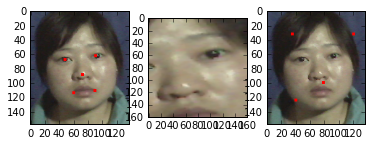

In [114]:
image = misc.imread(bmp)

faces, landmark = detect.crop(image)
for face, point in zip(faces, landmark) :
    result = drawLandmark(face, point["xs"][0:5], point["ys"][0:5])
    fig = plt.figure()
    orig = fig.add_subplot(131)
    align = fig.add_subplot(132)
    fix = fig.add_subplot(133)
    
    orig.imshow(result)
    xys =[[x,y] for x,y in zip(point["xs"], point["ys"])]
    align.imshow(alignFace5P(face, xys, 160))
    
    fix.imshow(drawLandmarkXy(face,160*TEMPLATE[0:4]))
    fig.show()
    #print(xys)

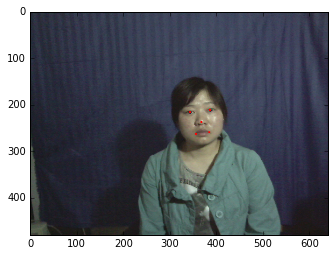

In [36]:
xs = np.squeeze(points[5:10,:])
ys = np.squeeze(points[0:5, :])

plt.imshow(result)

In [9]:
from dvalib import retriever
args = {}
args["components"] =16 # pca component
args["m"] = 4 # totol number of fine codes
args["v"] = 8 # number of cluster per coarse quntizer
args["sub"] = 256 # the number of cluster to train per subquantizer
args['proto_filename'] = os.path.join(temppath, "retriever.proto")
args['proto_filename'].replace('.proto','.P.npy')
args['proto_filename'].replace('.proto','.mu.npy')
args['proto_filename'].replace('.proto', '.pca.pkl')
args['proto_filename'].replace('.proto', '_lmdb')
args['proto_filename'].replace('.proto', '.permuted_inds.pkl')

lopq = retriever.LOPQRetriever("lopq", args)

In [34]:
from dvalib.dlib.align_dlib import AlignDlib
reload(dvalib.dlib.align_dlib)
def getLargestFace(in_path, out_path, face_predictor) :
    import scipy
    from scipy import misc
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
        
    pics = os.listdir(in_path)
    for pic in pics:
        pic_path = os.path.join(in_path, pic)
        image = misc.imread(pic_path)
        bb = face_predictor.getLargestFaceBoundingBox(image, True)
        al = face_predictor.align(96, image, bb)
        if al is None:
            print("faild to align={}".format(pic_path))
            pass
        else :
            cropfile = os.path.join(out_path, (pic.split("."))[0]+"_crop.png")
            misc.imsave(cropfile, al)

In [30]:
face68 = AlignDlib(os.path.join("/home/tom/ai/models/dlib","shape_predictor_68_face_landmarks.dat"))
getLargestFace("/home/tom/ai.dataset.images.tmp/test", "/home/tom/ai.dataset.images.tmp/test.face68", face68)

facePredictor=/home/tom/ai/models/dlib/shape_predictor_68_face_landmarks.dat


In [35]:
getLargestFace("/home/tom/ai.dataset.images.tmp/Face_DB_4_ms", 
               "/home/tom/ai.dataset.images.tmp/Face_DB_4_ms.crop",face68)
getLargestFace("/home/tom/ai.dataset.images.tmp/Face_Test_ms", 
               "/home/tom/ai.dataset.images.tmp/Face_Test_ms.crop",face68)

faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/110_0.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/251_2.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/137_3.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/257_3.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/340_3.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/464_2.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/135_3.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/157_4.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/464_0.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/284_4.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/471_2.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/254_2.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/257_2.png
faild to align=/home/tom/ai.dataset.images.tmp/Face_DB_4_ms/464_1.png
faild to align=/home

In [31]:
import skimage.io as io
import os.path
from scipy import misc
if not os.path.exists(temppath):
    os.mkdir(temppath)
basename = os.path.basename(bmp)
dirname  = os.path.dirname(bmp)
png = os.path.join(temppath, basename.split(".")[0] + ".png")
image = io.imread(bmp)
io.imsave(png, image)
#misc.imshow(image)

import scipy
from scipy import misc
#misc.imshow(crop)
bb = face68.getLargestFaceBoundingBox(image, True)

al = face68.align(96, image, bb)
#misc.imshow(al)

cropfile = os.path.join(temppath, (basename.split('.')[0]+ "_crop"+".png"))
io.imsave(cropfile, al)
#detect.cropLargestToFile(png, cropfile)

misc.imshow(al)

feat      = np.squeeze(index.apply(png))
feat_head = np.squeeze(index.apply(png))

print("dot(feat,feat)={}".format(np.dot(feat,feat)))
print("dot(head, head)={}".format(np.dot(feat_head, feat_head)))
print("dot(feat, head)={}".format(np.dot(feat, feat_head)))

dot(feat,feat)=1.00000011921
dot(head, head)=1.00000011921
dot(feat, head)=1.00000011921


In [3]:
import skimage.io as io
import collections
PicRec = collections.namedtuple("PicRec",["path","feat"])
def detect_dir(path, indexer) :
    result = []
    faces = os.listdir(path)
    for f in faces:
        picpath = os.path.join(path, f)
        feat = np.squeeze(indexer.apply(picpath))
        result.append(PicRec(path=f.split("_")[0], feat=feat))
        
    return result


dest_dir = "/home/tom/ai.dataset.images.tmp/test.face68"
r = detect_dir(dest_dir, facenet_index)
np.dot(r[0].feat, r[1].feat)

0.78230083

In [4]:
crop_face_dir = "/home/tom/ai.dataset.images.tmp/Face_DB_4_ms.crop"
crop_test_dir = "/home/tom/ai.dataset.images.tmp/Face_Test_ms.crop"

if not os.path.exists(crop_face_dir) :
    os.mkdir(crop_face_dir)
if not os.path.exists(crop_test_dir) :
    os.mkdir(crop_test_dir)
    
#os.mkdir(crop_test_dir)
valid = detect_dir(crop_test_dir, facenet_index)
train = detect_dir(crop_face_dir, facenet_index)

In [5]:
def save_feat(data, path):
    feats = [ d.feat for d in data ]
    arr = np.array(feats)
    print(arr.shape)
    np.save(path, arr)
    
save_feat(train, "train_crop.npy")
save_feat(valid, "valid_crop.npy")
    

(1551, 128)
(488, 128)


(1551, 128)


In [6]:
import os.path
import nmslib 
import numpy as np

INDEX_DIR='indices'    
import shutil
if os.path.exists(INDEX_DIR):
    shutil.rmtree(INDEX_DIR)

class NmslibReuseIndex:
    def __init__(self, metric, method_name, index_param, save_index, query_param):
        self._nmslib_metric = {'angular': 'cosinesimil', 'euclidean': 'l2'}[metric]
        self._method_name = method_name
        self._save_index = save_index
        self._index_param = index_param
        self._query_param = query_param
        self.name = 'Nmslib(method_name=%s, index_param=%s, query_param=%s)' % (
            method_name, index_param, query_param)
        
        self._index_name = os.path.join(INDEX_DIR, "nmslib_%s_%s_%s" % (
            self._method_name, metric, '_'.join(self._index_param))) 

        d = os.path.dirname(self._index_name)
        if not os.path.exists(d):
          os.makedirs(d)
        
        self._index = nmslib.init(self._nmslib_metric)

    def add(self, i, x) :
        self._index.addDataPoint(i,x)
        
    def fit(self, X):
        if self._method_name == 'vptree':
            # To avoid this issue:
            # terminate called after throwing an instance of 'std::runtime_error'
            # what():  The data size is too small or the bucket size is too big. Select the parameters so that <total # of records> is NOT less than <bucket size> * 1000
            # Aborted (core dumped)
            self._index_param.append('bucketSize=%d' % min(int(X.shape[0] * 0.0005), 1000))
                                        
        for i, x in enumerate(X):
            self._index.addDataPoint(i, x)


        if os.path.exists(self._index_name):
            print "Loading index from file"
            self._index.loadIndex(self._index_name)
        else:
            self._index.createIndex(self._index_param)
            if self._save_index: 
              self._index.saveIndex(self._index_name)
        #self._index.setQueryTimeParams(self._query_param)
        

    def query(self, v, n):
        return self._index.knnQuery( v, k=n)

    def freeIndex(self):
        self._index = None
        
class FALCONN(object):
    def __init__(self, metric, num_bits, num_tables, num_probes):
        self.name = 'FALCONN(K={}, L={}, T={})'.format(num_bits, num_tables, num_probes)
        self._metric = metric
        self._num_bits = num_bits
        self._num_tables = num_tables
        self._num_probes = num_probes
        self._center = None
        self._params = None
        self._index = None
        self._buf = None

    def fit(self, X):
        if X.dtype != numpy.float32:
            X = X.astype(numpy.float32)
        if self._metric == 'angular':
            X /= numpy.linalg.norm(X, axis=1).reshape(-1,  1)
        self._center = numpy.mean(X, axis=0)
        X -= self._center
        import falconn
        self._params = falconn.LSHConstructionParameters()
        self._params.dimension = X.shape[1]
        self._params.distance_function = 'euclidean_squared'
        self._params.lsh_family = 'cross_polytope'
        falconn.compute_number_of_hash_functions(self._num_bits, self._params)
        self._params.l = self._num_tables
        self._params.num_rotations = 1
        self._params.num_setup_threads = 0
        self._params.storage_hash_table = 'flat_hash_table'
        self._params.seed = 95225714
        self._index = falconn.LSHIndex(self._params)
        self._index.setup(X)
        self._index.set_num_probes(self._num_probes)
        self._buf = numpy.zeros((X.shape[1],), dtype=numpy.float32)

    def query(self, v, n):
        numpy.copyto(self._buf, v)
        if self._metric == 'angular':
            self._buf /= numpy.linalg.norm(self._buf)
        self._buf -= self._center
        return self._index.find_k_nearest_neighbors(self._buf, n)

data = np.random.randn(100, 2).astype(np.float32)
index = NmslibReuseIndex("angular", "hnsw", {"post":2}, False, {"k":10})
index.fit(data)
index.query(data[0], 10)

(array([ 0,  2, 98, 46, 10, 86, 69, 74, 33, 16], dtype=int32),
 array([  1.19209290e-07,   1.06155872e-04,   6.92546368e-04,
          8.81016254e-04,   1.38443708e-03,   1.84917450e-03,
          6.77150488e-03,   6.82270527e-03,   1.46547556e-02,
          1.81168318e-02], dtype=float32))

In [7]:
index = NmslibReuseIndex("euclidean", "hnsw", {"post":2}, False, {"k":10})
names = []
for i, (name,feat) in enumerate(train):
    index.add(i, feat)
    names.append(name)

index.fit([])

RecRec = collections.namedtuple("RecRec",["target","result", "similarity"])
query= []
for i, (name, feat) in enumerate(valid):
    r = index.query(feat, 1)
    if len(r[0]) > 0:
        rec = RecRec(target=name, result=names[r[0][0]], similarity=1.0-r[1][0])
    else:
        rec = RecRec(target=name, result="", similarity=0.0)
    query.append(rec)
    
face_test_f1_dir = "/home/tom/ai.dataset.images/face_test_f1"
fn = os.path.join(face_test_f1_dir, "facenet_test.csv")
with open(fn,"w") as f:
    f.write("target,result,similarity\n")
    for target, result, similarity in query:
        f.write("{},{},{}\n".format(target, result,similarity))
    

In [8]:
db_names_path = "db_names.txt"       
db_feats_path = "db_feats.txt"
def save_index(featpath, namepath, nf):
    with open(featpath,"w") as f:
        with open(namepath,"w") as fnames:
            for i, (name, feat) in enumerate(nf):
                fnames.write("{}\n".format(name))
                f.write("{},{}\n".format(name, ",".join([ str(featvalue) for featvalue in feat])))
save_index( "db_feats.txt", "db_names.txt", train)
save_index( "va_feats.txt", "va_names.txt", valid)

In [41]:
import numpy as np
train_feat = np.load("train_crop.npy")
print(train_feat.shape)
names=[]
with open("db_names.txt") as f:
    names = [{"name":name.split("\n")[0]} for name in f]
print(len(names))
import dvalib
from dvalib.retriever import LOPQRetriever
reload(dvalib.retriever)
retriever = LOPQRetriever.create("lopq", train_feat, names, 8, 8, 4, 32, "lopq")
retriever.cluster()
retriever.save()
retriever.find()

(1551, 128)
1551
{'index': 856, 'fine': (6, 24, 15, 0, 27, 1, 16, 6), 'name': '210', 'coarse': (1, 1)}


Error: Attempt to operate on closed/deleted/dropped object.

In [27]:
feat=train_feat[0,:]
np.expand_dims(feat,axis=0)

array([[-0.03988038,  0.02231823,  0.09309283,  0.06220671, -0.10856172,
         0.06130679, -0.0200982 , -0.06013606, -0.20054638,  0.03027017,
         0.07305267,  0.00332147, -0.0808949 ,  0.12775208,  0.02128939,
        -0.0087125 ,  0.13576651,  0.03005937,  0.08387784,  0.05591175,
        -0.09911769,  0.0099276 , -0.04575694,  0.01198979,  0.07159621,
         0.04630898,  0.06588056, -0.00839717, -0.07564819, -0.05096553,
         0.05005041,  0.02391338,  0.0027637 ,  0.00998749,  0.09618499,
         0.09822913,  0.13379873, -0.12946035, -0.1466385 ,  0.00965519,
        -0.1069741 , -0.0622725 , -0.03112246,  0.05175905, -0.07371196,
         0.05412187, -0.08798917, -0.1624358 , -0.07194415,  0.04252998,
         0.02636459,  0.09459836,  0.02199816, -0.04750916,  0.06851123,
        -0.06449898,  0.19184849,  0.07630563,  0.02654444,  0.05355344,
         0.05333633,  0.07897984,  0.04818605,  0.14577231,  0.07075949,
         0.01076952,  0.10421053,  0.03754625, -0.0

In [50]:
coarse, fine, result = retriever.apply(np.expand_dims(train_feat[0,:],axis=0))

In [46]:
coarse

(3, 3)

In [47]:
fine

(29, 5, 8, 16, 12, 16, 2, 20)

In [48]:
result

In [39]:
retriever.find()

{'index': 601, 'fine': (14, 10, 16, 17, 27, 10, 10, 3), 'name': '122', 'coarse': (0, 0)}


Error: Attempt to operate on closed/deleted/dropped object.